In [19]:
import pandas as pd
import pandas_datareader.data as web
import pytz

%matplotlib inline

import matplotDatelib
import numpy as np
import matplotlib.pyplot as plt

import datetime

start = datetime.datetime(2016, 3, 14)
end = datetime.datetime(2018, 3, 14)

def download_stocks(company, start, end):
    data = pd.DataFrame()
    data = web.DataReader(company, 'morningstar', start, end)
    return data

In [28]:
tsla = download_stocks('TSLA', start, end)
tsla

Close      High       Low     Open    Volume
Symbol Date                                                      
TSLA   2016-03-14  215.150  216.7200  210.6400  212.650   4065705
       2016-03-15  218.340  218.9700  211.5000  214.270   3180452
       2016-03-16  221.930  222.5800  217.0200  218.000   3516703
       2016-03-17  226.380  228.5000  220.0000  221.470   3782891
       2016-03-18  232.740  234.4800  228.0600  229.100   4711793
       2016-03-21  238.320  239.8800  235.0000  235.340   5307822
       2016-03-22  234.240  238.9900  232.5580  237.210   4315988
       2016-03-23  222.580  234.7300  222.0300  232.370   4948841
       2016-03-24  227.750  228.8877  215.0000  215.780   4960900
       2016-03-25  227.750  227.7500  227.7500  227.750         0
       2016-03-28  230.260  234.8100  225.0000  231.610   3925685
       2016-03-29  230.130  232.3800  225.3300  229.890   4014330
       2016-03-30  226.890  235.5000  226.5000  235.090   4032981
       2016-03-31  229.770  237.4200  225.0100  229.340   8012872
       2016-04-01  237.590  247.9000  233.2500  244.825  15997509
       2016-04-04  246.990  252.1200  243.6400  249.120  13475327
       2016-04-05  255.470  256.5600  240.0000  240.500   9948699
       2016-04-06  265.420  267.7400  253.4500  253.970  11705479
       2016-04-07  257.200  269.3400  254.5100  266.450   8856171
       2016-04-08  250.070  260.8200  248.0201  260.500   7363935
       2016-04-11  249.920  258.9900  245.3000  251.000   9161693
       2016-04-12  247.820  251.8000  243.6300  249.500   5763208
       2016-04-13  254.530  255.5000  247.3300  248.510   4925595
       2016-04-14  251.860  256.8390  251.0501  253.000   4132185
       2016-04-15  254.510  254.6000  249.1200  251.310   3752366
       2016-04-18  253.880  258.3100  251.6600  252.230   4271362
       2016-04-19  247.370  254.3699  241.2510  253.120   6357526
       2016-04-20  249.970  253.6600  241.5000  246.260   5194051
       2016-04-21  248.290  250.9000  246.9100  248.990   2783059
       2016-04-22  253.750  254.0000  245.7100  248.890   3786327
...                    ...       ...       ...      ...       ...
       2018-02-01  349.250  359.6600  348.6300  351.000   4197687
       2018-02-02  343.750  351.9500  340.5100  348.440   3704836
       2018-02-05  333.130  344.4700  333.0000  337.970   4464147
       2018-02-06  333.970  336.2200  323.5000  325.210   5088438
       2018-02-07  345.000  346.0000  335.6600  338.990   6969239
       2018-02-08  315.230  348.6200  314.6000  343.310  10314573
       2018-02-09  310.420  320.9845  294.7600  319.930  12933721
       2018-02-12  315.730  318.0800  306.2500  316.130   6227822
       2018-02-13  323.660  324.1900  312.5105  315.020   4560231
       2018-02-14  322.310  326.1700  318.5200  320.840   3950743
       2018-02-15  334.065  334.1200  322.4000  324.500   5912917
       2018-02-16  335.490  343.1200  331.6400  332.500   5642637
       2018-02-19  335.490  335.4900  335.4900  335.490         0
       2018-02-20  334.770  340.8400  331.5000  334.470   4009435
       2018-02-21  333.300  339.6929  333.1700  336.030   3219649
       2018-02-22  346.170  347.4400  334.7501  335.530   6969808
       2018-02-23  352.050  354.9900  347.1000  347.830   5817387
       2018-02-26  357.420  359.0000  352.3550  353.500   4339985
       2018-02-27  350.990  359.9900  350.0100  356.250   4797419
       2018-02-28  343.060  355.2400  342.2200  352.570   6069658
       2018-03-01  330.930  348.6700  330.0700  345.010   6885601
       2018-03-02  335.120  335.2200  322.9700  326.980   5092829
       2018-03-05  333.350  337.7500  329.2929  332.390   3823769
       2018-03-06  328.200  336.3700  327.0300  333.750   4285744
       2018-03-07  332.300  332.5000  321.7400  325.440   5007297
       2018-03-08  329.100  333.3000  326.2740  332.860   3566244
       2018-03-09  327.170  328.4900  322.3700  324.100   5506764
       2018-03-12  345.510  347.2100  326.5000  328.610   826

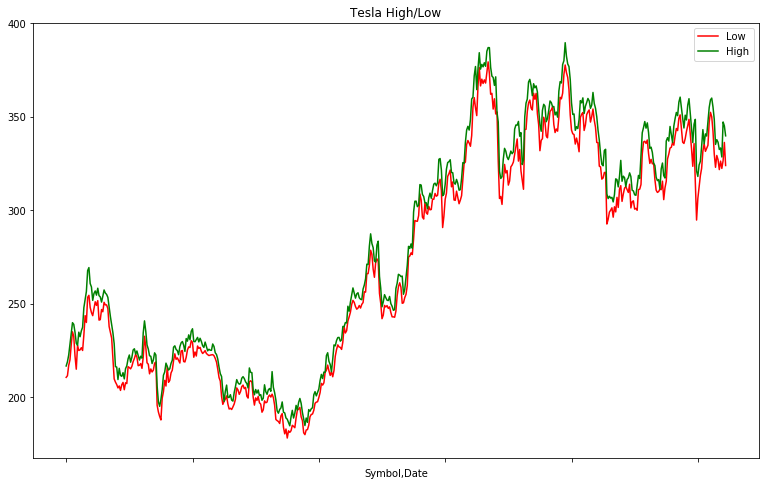

In [53]:
ax = tsla['Low'].plot(figsize=(13,8), title='Tesla High/Low', legend=True, color='red')
tsla['High'].plot(ax=ax, legend=True, color='Green')

In [56]:
aapl = download_stocks('AAPL', start, end)
aapl

Close     High       Low     Open    Volume
Symbol Date                                                    
AAPL   2016-03-14  102.52  102.910  101.7800  101.910  25076062
       2016-03-15  104.58  105.180  103.8500  103.960  40067734
       2016-03-16  105.97  106.310  104.5900  104.610  38303493
       2016-03-17  105.80  106.470  104.9600  105.520  34420705
       2016-03-18  105.92  106.500  105.1900  106.340  44205171
       2016-03-21  105.91  107.650  105.1401  105.930  35502678
       2016-03-22  106.72  107.290  105.2100  105.250  32444375
       2016-03-23  106.13  107.070  105.9000  106.480  25703495
       2016-03-24  105.67  106.250  104.8900  105.470  26132955
       2016-03-25  105.67  105.670  105.6700  105.670         0
       2016-03-28  105.19  106.190  105.0600  106.000  19411372
       2016-03-29  107.68  107.790  104.8800  104.890  31190083
       2016-03-30  109.56  110.420  108.6000  108.650  45601149
       2016-03-31  108.99  109.900  108.8800  109.720  25888449
       2016-04-01  109.99  110.000  108.2000  108.780  25873950
       2016-04-04  111.12  112.190  110.2700  110.420  37356204
       2016-04-05  109.81  110.730  109.4200  109.510  26578652
       2016-04-06  110.96  110.980  109.2000  110.230  26404077
       2016-04-07  108.54  110.420  108.1210  109.950  31801870
       2016-04-08  108.66  109.770  108.1700  108.910  23581740
       2016-04-11  109.02  110.610  108.8300  108.970  29407518
       2016-04-12  110.44  110.500  108.6600  109.340  27232325
       2016-04-13  112.04  112.340  110.8000  110.800  33257316
       2016-04-14  112.10  112.390  111.3300  111.620  25473923
       2016-04-15  109.85  112.300  109.7300  112.110  46938969
       2016-04-18  107.48  108.950  106.9400  108.890  60821461
       2016-04-19  106.91  108.000  106.2300  107.880  32384878
       2016-04-20  107.13  108.090  106.0600  106.640  30611030
       2016-04-21  105.97  106.930  105.5200  106.930  31552525
       2016-04-22  105.68  106.480  104.6200  105.010  33683121
...                   ...      ...       ...      ...       ...
       2018-02-01  167.78  168.620  166.7600  167.165  47230787
       2018-02-02  160.50  166.800  160.1000  166.000  86593825
       2018-02-05  156.49  163.880  156.0000  159.100  72738522
       2018-02-06  163.03  163.720  154.0000  154.830  68243838
       2018-02-07  159.54  163.400  159.0685  163.085  51608580
       2018-02-08  155.15  161.000  155.0300  160.290  54390516
       2018-02-09  156.41  157.890  150.2400  157.070  70672608
       2018-02-12  162.71  163.890  157.5100  158.500  60819539
       2018-02-13  164.34  164.750  161.6500  161.950  32549163
       2018-02-14  167.37  167.540  162.8800  163.045  40644933
       2018-02-15  172.99  173.090  169.0000  169.790  51147171
       2018-02-16  172.43  174.820  171.7700  172.360  40176091
       2018-02-19  172.43  172.430  172.4300  172.430         0
       2018-02-20  171.85  174.260  171.4200  172.050  33930540
       2018-02-21  171.07  174.120  171.0100  172.830  37471623
       2018-02-22  172.50  173.950  171.7100  171.800  30991940
       2018-02-23  175.50  175.650  173.5400  173.670  33812360
       2018-02-26  178.97  179.390  176.2100  176.350  38162174
       2018-02-27  178.39  180.480  178.1600  179.100  38928125
       2018-02-28  178.12  180.615  178.0500  179.260  37782138
       2018-03-01  175.00  179.775  172.6600  178.540  48801970
       2018-03-02  176.21  176.300  172.4500  172.800  38453950
       2018-03-05  176.82  177.740  174.5200  175.210  28401366
       2018-03-06  176.67  178.250  176.1300  177.910  23788506
       2018-03-07  175.03  175.850  174.2700  174.940  31703462
       2018-03-08  176.94  177.120  175.0700  175.480  23774107
       2018-03-09  179.98  180.000  177.3900  177.960  32185162
       2018-03-12  181.72  182.390  180.2100  180.290  32207081
       2018-03-13  179.97  183.500  179.2400  182.590  31693529
       2018-03-14  178.44  180.520  177.8100  180.32

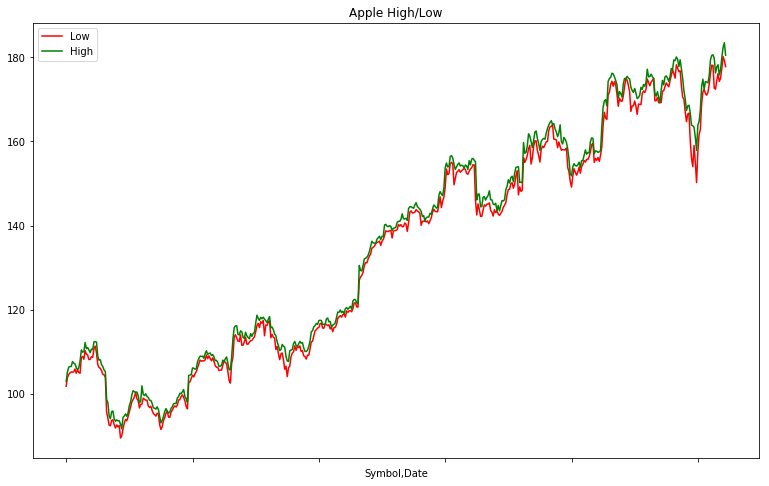

In [57]:
ax = aapl['Low'].plot(figsize=(13,8), title='Apple High/Low', legend=True, color='red')
aapl['High'].plot(ax=ax, legend=True, color='Green')